## Synth

In [1]:
from hum.pyo_util import Synth

## Simple Synth test

Let's start by running a simple test with the simplest of synthesizers (one that just plays a pure tone for a given frequency). 
This will allow us to have a quick overview of what you can do with a synth.

In [22]:
# the current version of this test is here:
from hum.tests.test_pyo_synth import test_synth_frequency_sequence
test_synth_frequency_sequence()  # uncomment to run the test (but we'll do it again below)


In [21]:
import time
from pyo import Sine
import recode 
from hum.pyo_util import Synth, DFLT_PYO_SR, round_event_times
from hum.extra_util import estimate_frequencies

base_freq = 220

# Make a synth that plays a simple sine waves
def simple_sine(freq=base_freq):
    return Sine(freq=freq)

s = Synth(simple_sine)

# Define a sequence of frequencies to play
freq_sequence = [base_freq] + [base_freq * 3 / 2, base_freq * 2]

# Play the frequencies in sequence
with s:
    time.sleep(1)  # let base_freq play for a second
    s(freq=freq_sequence[1])  # Change to 330 Hz
    time.sleep(1)  # ... play that for a second
    s['freq'] = freq_sequence[
        2
    ]  # ...then change to 440 Hz (doing it differently)
    time.sleep(1)  # ... play that for a second
    # ... tnad htne exit the context manager, which stops the synth

# These actions on the synth should be recorded, with the time of the
# change recorded as well.
# You can get the recorded events like so:
events = s.get_recording()
# Often, you might want to round timing for consistency and readability:
events = list(round_event_times(events, round_to=0.1))
# These are the events we expect to see:
expected_events = [
    (
        0.0,
        {
            # Note that the first event is the event create by the defaults of the synth function (and other internals)
            'freq': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
        },
    ),
    (1.0, {'freq': 330.0}),
    (2.0, {'freq': 440}),
    # Note that the last event's "knobs" dict is empty, as we are just recording when the synth is stopped
    (3.0, {}),
]
assert events == expected_events, f"Expected {expected_events}, got {events}"

# You can "render" these. By default, the synth will render to a WAV format bytes.
# This means that you can then save these, play these, or do whatever you want with them.
wav_bytes = s.render_events(events)

# Verify basic properties of the rendered audio
assert isinstance(wav_bytes, bytes)
assert len(wav_bytes) > 0, "No bytes returned"

# Decode the WAV bytes
wf, sr = recode.decode_wav_bytes(wav_bytes)

# Verify sample rate and duration
assert sr == DFLT_PYO_SR, "Sample rate mismatch"
total_duration = len(wf) / sr
assert (
    abs(total_duration - 3.0) < 0.1
), f"Expected ~3 seconds of audio, got {total_duration}"


In [ ]:
events == [(0.0, {'freq': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (1.0, {'freq': 330.0}),
 (2.0, {'freq': 440}),
 (3.0, {})]


True

In [ ]:
from hum.pyo_util import ReplayEvents


def simple_sine(freq=base_freq):
    return Sine(freq=freq)

s = Synth(simple_sine)

events == [
    (0.0, {'freq': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (1.0, {'freq': 330.0}),
 (2.0, {'freq': 440}),
 (3.0, {})]

s.play_events(events)

In [ ]:
from hum.pyo_util import ReplayEvents

events == [
    (0.0, {'freq': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (1.0, {'freq': 330.0}),
 (2.0, {'freq': 440}),
 (3.0, {})]

list((ReplayEvents(events))) == events

[{'freq': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0}},
 {'freq': 330.0},
 {'freq': 440},
 {}]

## Interactive, in a REPL

In [ ]:
from pyo import LFO, Adsr, Sine
from hum.pyo_util import Synth
from time import sleep

# Note that here we explicitly tell Synth what arguments are "dials" and what are "settings"
# (See https://github.com/thorwhalen/hum/discussions/4#discussioncomment-13011738 for what the difference is)
# If all arguments are dials, you don't have to specify them though
@Synth(dials='freq', settings='waveform attack')
def simple_waveform_synth(freq=440, attack=0.01, waveform='sine'):
    env = Adsr(attack=attack, decay=0.1, sustain=0.8, release=0.1, dur=0, mul=0.5).play()
    wave = {
        'sine': Sine,
        'triangle': lambda freq, mul: LFO(freq=freq, type=3, mul=mul),
        'square': lambda freq, mul: LFO(freq=freq, type=1, mul=mul),
    }.get(waveform, Sine)
    return wave(freq=freq, mul=env)


In [ ]:
# If you're going to have a live session -- i.e., you want to play the synth interactively 
# -- you need to start the synth (but remember to stop it, and remember that if you make any errors
# it won't close the synth for you, so you might get things like kernel panics or other errors)
# In general, you want to work with a synth in a context manager.
simple_waveform_synth.start()
# this will start playing sound... you can then update the knobs of your synth like so:

In [ ]:
simple_waveform_synth(freq=440 * 3 / 2)  # change to 660 Hz
# see how the sound continues to play, but now it's a different frequency?

In [ ]:
# here' we'll change the frequency back to where it was, but with a different waveform
# This shows you that you can change multiple knobs at the same time
simple_waveform_synth(freq=440, waveform='triangle') 


In [ ]:
simple_waveform_synth(waveform='square', attack=0.5)  # swith to square wave, and also change the attack time
# But note that you don't hear the change in attack time until the next note is played!


In [ ]:
simple_waveform_synth.stop()  # stop the synth

In [ ]:
# Note that if start the synth again, it will start with it's current knobs (so will) still 
# have a square waveform). The synth doesn't reset automatically when you start it again.
simple_waveform_synth.start()  # start the synth again

In [ ]:
simple_waveform_synth(waveform='sine')  # let's put the sine back (hear that the attack is still 0.5)


In [ ]:
simple_waveform_synth.stop()  # stop the synth

## Precomputed knob changes

We can emulate the interactivity above by sleeping in between actions.

In [4]:
from pyo import LFO, Adsr, Sine
from hum.pyo_util import Synth
from time import sleep

@Synth(dials='freq', settings='waveform attack')
def simple_waveform_synth(freq=440, attack=0.01, waveform='sine'):
    env = Adsr(attack=attack, decay=0.1, sustain=0.8, release=0.1, dur=0, mul=0.5).play()
    wave = {
        'sine': Sine,
        'triangle': lambda freq, mul: LFO(freq=freq, type=3, mul=mul),
        'square': lambda freq, mul: LFO(freq=freq, type=1, mul=mul),
    }.get(waveform, Sine)
    return wave(freq=freq, mul=env)

with simple_waveform_synth as s:
    sleep(1) # to let the synth play it's defaults for a second
    s(freq=440 * 3 / 2)  # change to 660 Hz
    sleep(1) 
    s(freq=440, waveform='triangle') 
    sleep(0.5) # let's shake it up a bit and wait for shorter
    s(waveform='square', attack=0.5)  # swith to square wave, and also change the attack time
    sleep(2)  # wait for a bit longer...
    s(waveform='sine')  # let's put the sine back (hear that the attack is still 0.5)
    sleep(1) # if you don't wait here for a bit, you won't hear the last change!


All of these events were recorded (even during your interactive session before).
Here's how you can get these events. 
They are timestamped according to when they happened. 
Note the first even is making the synth with it's defaults. 
The last event was stopping the synth.

In [ ]:
events = simple_waveform_synth.get_recording()
events

[(0,
  {'freq': {'value': 440, 'time': 0.025, 'mul': 1, 'add': 0},
   'attack': 0.01,
   'waveform': 'sine'}),
 (1.0052499771118164, {'freq': 660.0}),
 (2.007974863052368, {'freq': 440, 'waveform': 'triangle'}),
 (2.0084967613220215, {'waveform': 'triangle'}),
 (2.515920877456665, {'waveform': 'square', 'attack': 0.5}),
 (2.518988609313965, {'waveform': 'square', 'attack': 0.5}),
 (4.524500846862793, {'waveform': 'sine'}),
 (4.525563716888428, {'waveform': 'sine'}),
 (5.528840780258179, {})]

You can get a simpler version by rounding the event timestamps


In [ ]:
from hum.pyo_util import round_event_times

list(round_event_times(simple_waveform_synth.get_recording(), 0.1))


[(0.0,
  {'freq': {'value': 440, 'time': 0.025, 'mul': 1, 'add': 0},
   'attack': 0.01,
   'waveform': 'sine'}),
 (1.0, {'freq': 660.0}),
 (2.0, {'freq': 440, 'waveform': 'triangle'}),
 (2.0, {'waveform': 'triangle'}),
 (2.5, {'waveform': 'square', 'attack': 0.5}),
 (2.5, {'waveform': 'square', 'attack': 0.5}),
 (4.5, {'waveform': 'sine'}),
 (4.5, {'waveform': 'sine'}),
 (5.5, {})]

## Composing in knobs

Whether you got these events from a recording, editted them, or just wrote them from scratch, you can do all kinds of things with them. 

In [26]:
events = [
    (
        0.0,
        {
            'freq': {'value': 440, 'time': 0.025, 'mul': 1, 'add': 0},
            'attack': 0.01,
            'waveform': 'sine',
        },
    ),
    (1.0, {'freq': 660.0}),
    (2.0, {'freq': 440, 'waveform': 'triangle'}),
    (2.0, {'waveform': 'triangle'}),
    (2.5, {'waveform': 'square', 'attack': 0.5}),
    (2.5, {'waveform': 'square', 'attack': 0.5}),
    (4.5, {'waveform': 'sine'}),
    (4.5, {'waveform': 'sine'}),
    (5.5, {}), 
]

### Playing events

In [27]:
@Synth(dials='freq', settings='waveform attack')
def simple_waveform_synth(freq=440, attack=0.01, waveform='sine'):
    env = Adsr(attack=attack, decay=0.1, sustain=0.8, release=0.1, dur=0, mul=0.5).play()
    wave = {
        'sine': Sine,
        'triangle': lambda freq, mul: LFO(freq=freq, type=3, mul=mul),
        'square': lambda freq, mul: LFO(freq=freq, type=1, mul=mul),
    }.get(waveform, Sine)
    return wave(freq=freq, mul=env)


simple_waveform_synth.replay_events(events)

### Rendering the events: Getting the waveform (wav bytes) for the events played through synth

In [ ]:
import recode 

wav_bytes = simple_waveform_synth.render_events(events)
wf, sr = recode.decode_wav_bytes(wav_bytes)

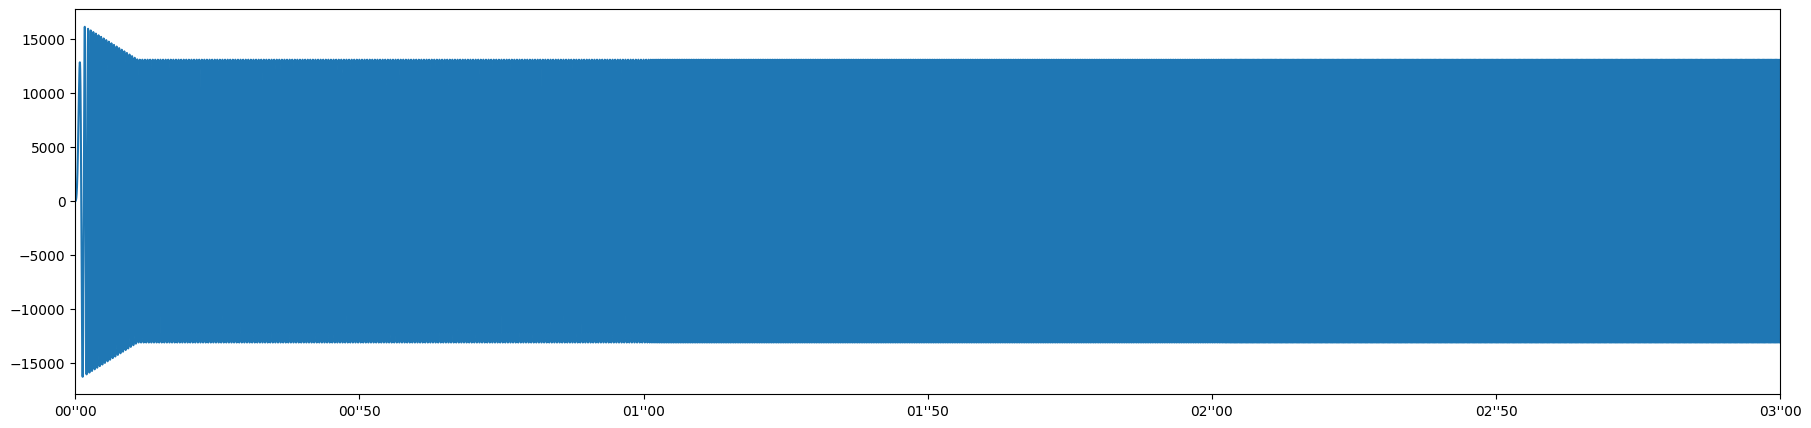

In [25]:
from hum import disp_wf 

disp_wf(wf, sr)

### 🎛️ Example 1: Basic Dual Oscillator Synth

In [ ]:
from hum.pyo_util import example_01_basic_dual_osc

wf, sr = example_01_basic_dual_osc()

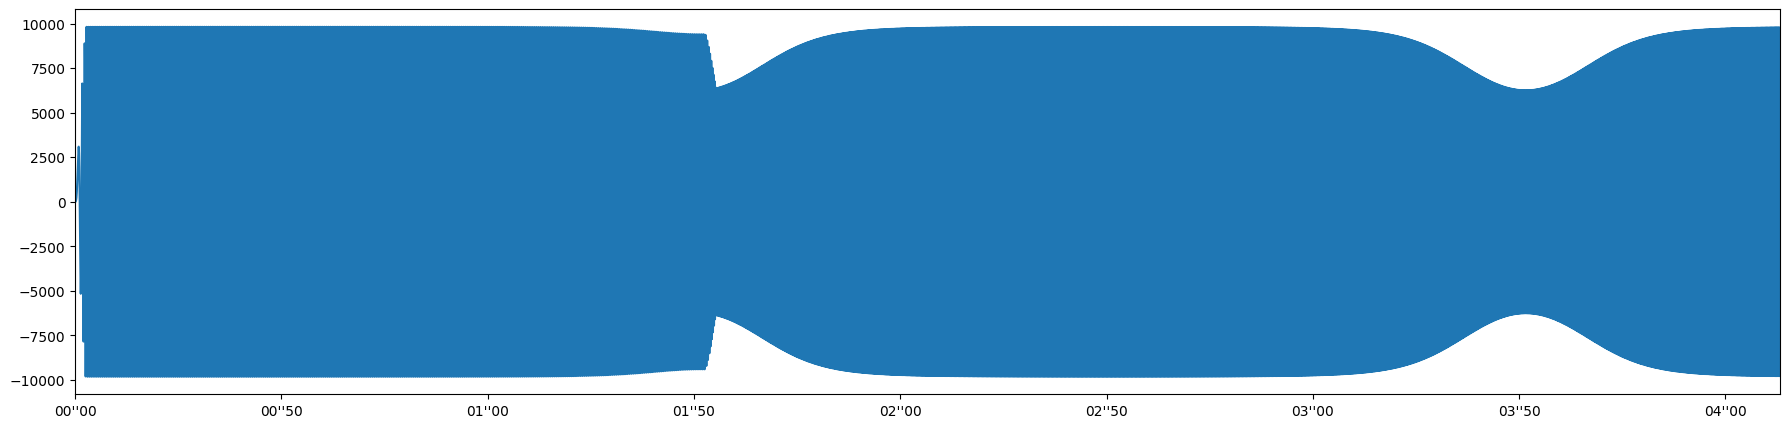

In [ ]:
from hum import disp_wf 

disp_wf(wf, sr)

### 🎛️ Example 2: Distortion and Reverb

In [ ]:
from hum.pyo_util import example_02_distortion_and_reverb

example_02_distortion_and_reverb()

### 🎛️ Example 3: Detuned Polyphonic Feel

In [ ]:
from hum.pyo_util import example_03_detuned_polyphonic_feel

example_03_detuned_polyphonic_feel()

### 🎛️ Example 4: Dynamic Tremolo and Filter Sweep

In [ ]:
from hum.pyo_util import example_04_dynamic_tremolo_and_filter_sweep

example_04_dynamic_tremolo_and_filter_sweep()

### 🎛️ Example 5: Offline Rendering

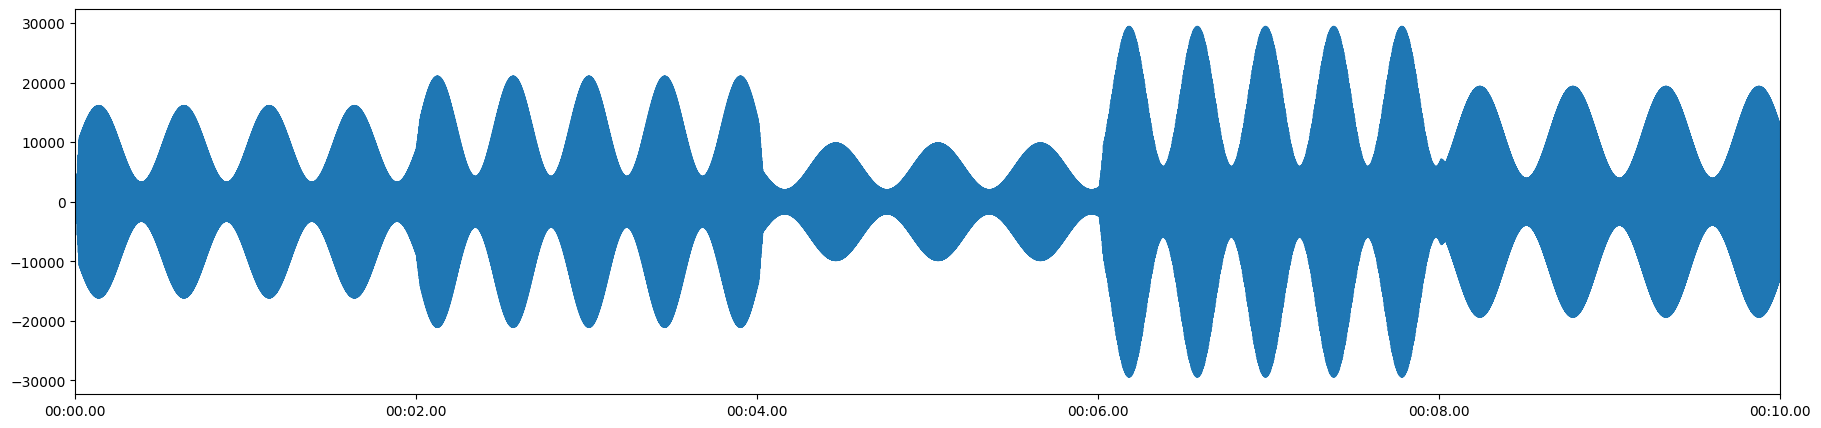

In [ ]:
from hum.pyo_util import example_05_offline_rendering
from hum import disp_wf


wf, sr = example_05_offline_rendering()

disp_wf(wf, sr)

# Scrap

In [ ]:
from hum.pyo_util import example_01_basic_dual_osc
from hum import disp_wf 

wf, sr = example_01_basic_dual_osc()

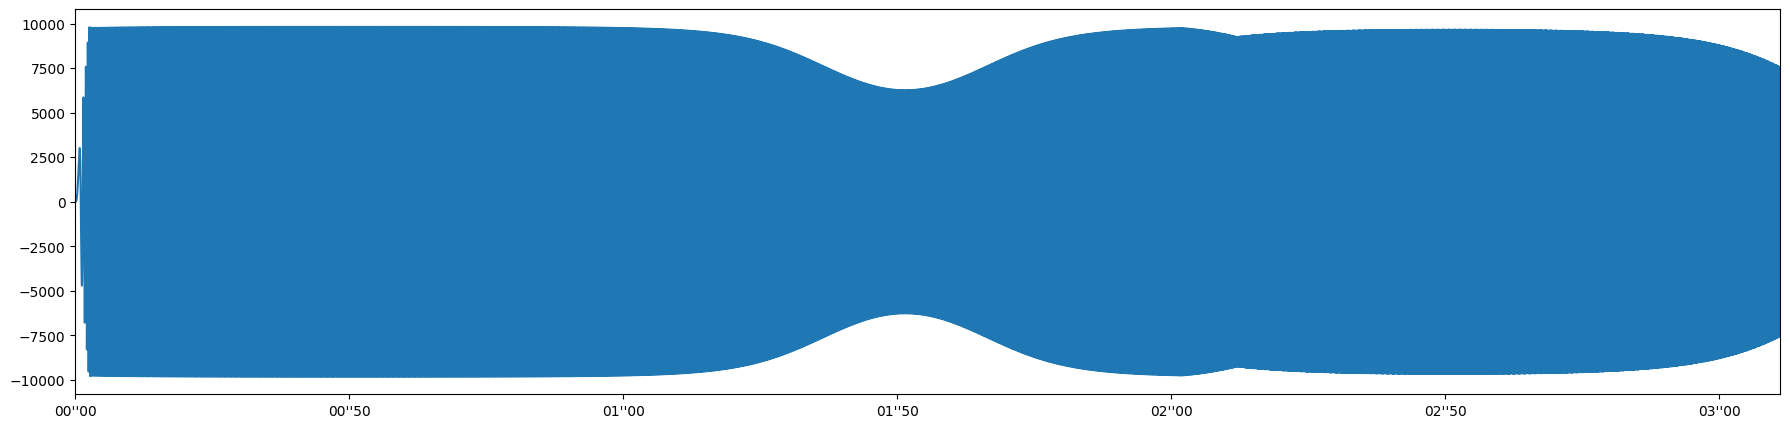

In [ ]:
from hum.pyo_util import example_06_knob_recording_playback
from hum import disp_wf 

wf, sr = example_06_knob_recording_playback()

disp_wf(wf, sr)


In [ ]:
records = [
    (
        0.0,
        {
            'freq1': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
            'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0},
            'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0},
            'lfo_freq': {'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0},
        },
    ),
    (0.06312704086303711, {'freq1': 440}),
    (1.0686028003692627, {'freq2': {'value': 550, 'time': 0.5, 'mul': 1, 'add': 0}}),
    (2.074380874633789, {'freq1': {'value': 880, 'time': 0.1}, 'freq2': 1100}),
    (3.0789618492126465, {}),
]

("recorded_frames=[(0.0, {'freq1': {'value': 220, 'time': 0.025, 'mul': 1, "
 "'add': 0}, 'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0}, "
 "'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0}, 'lfo_freq': "
 "{'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0}}), (7.295608520507812e-05, "
 "{'freq1': 440}), (1.0036530494689941, {'freq2': {'value': 550, 'time': 0.5, "
 "'mul': 1, 'add': 0}}), (2.01123309135437, {'freq1': {'value': 880, 'time': "
 "0.1}, 'freq2': 1100}), (3.0143749713897705, {})]")


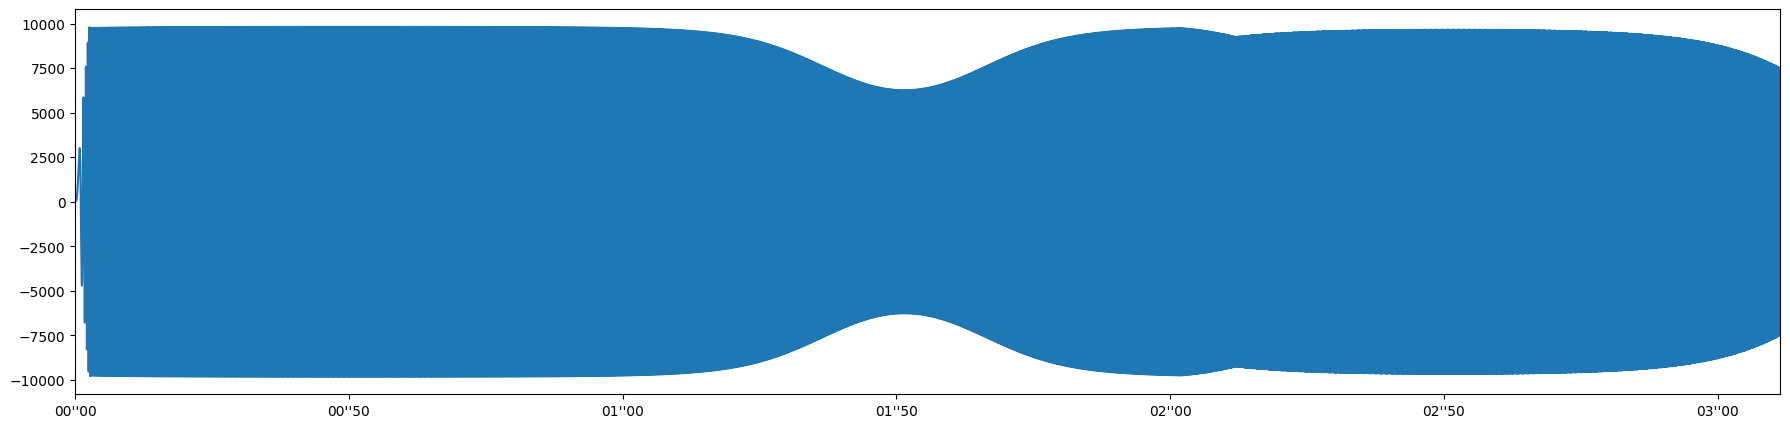

In [ ]:
from hum import Synth, disp_wf
import time
from pyo import Sine, ButLP, SigTo, Mix


# Dual sine oscillator with LFO-controlled lowpass filter
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)

synth = Synth(dual_osc_graph)

with synth:
    synth.knobs['freq1'] = 440
    time.sleep(1)
    synth.knobs['freq2'] = SigTo(550, time=0.5)  # Smooth shift
    time.sleep(1)
    synth.knobs.update(dict(freq1={'value': 880, 'time': 0.1}, freq2=1100))
    time.sleep(1)

recorded_frames = synth.get_recording()
from pprint import pprint
pprint(f"{recorded_frames=}")
assert len(recorded_frames) > 0, "No frames recorded"

wav_bytes = synth.render_events(recorded_frames)

disp_wf(wav_bytes)

In [ ]:
recorded_frames

[(0.0,
  {'freq1': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
   'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0},
   'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0},
   'lfo_freq': {'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (7.295608520507812e-05, {'freq1': 440}),
 (1.0036530494689941,
  {'freq2': {'value': 550, 'time': 0.5, 'mul': 1, 'add': 0}}),
 (2.01123309135437, {'freq1': {'value': 880, 'time': 0.1}, 'freq2': 1100}),
 (3.0143749713897705, {})]

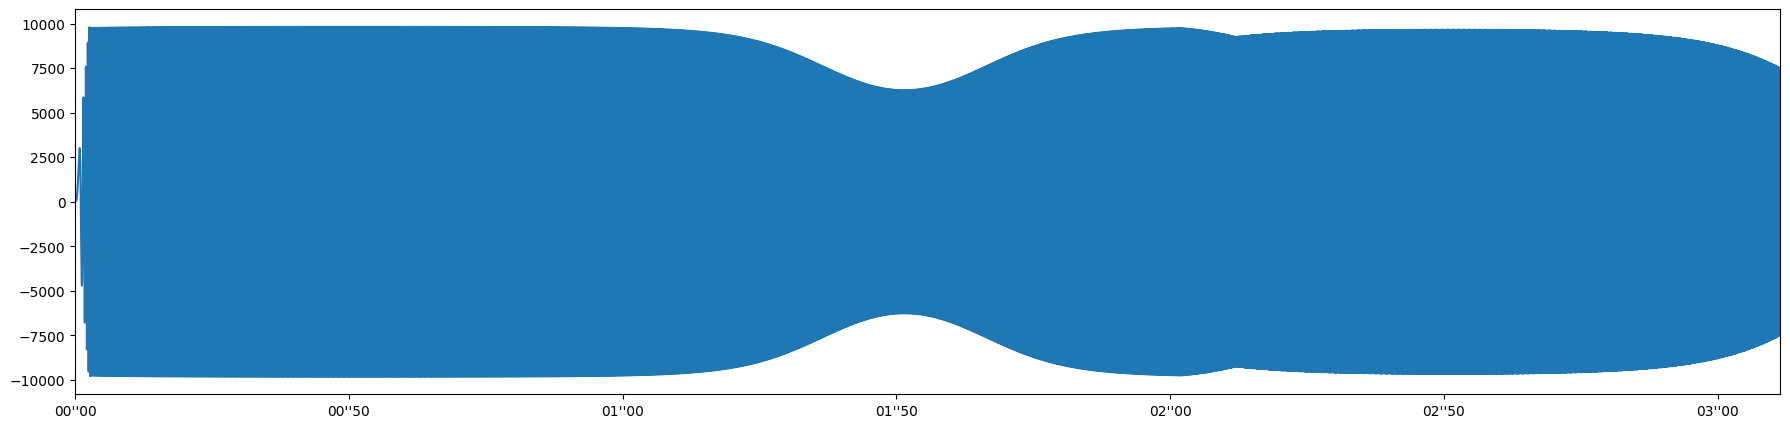

In [ ]:
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)

synth = Synth(dual_osc_graph)

wav_bytes = synth.render_events(recorded_frames)

disp_wf(wav_bytes)

In [ ]:
from hum.pyo_util import Synth, DFLT_PYO_SR
import time
from pyo import Sine, Mix, ButLP, SigTo

# Dual sine oscillator with LFO-controlled lowpass filter
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)

synth = Synth(dual_osc_graph, nchnls=2)
# 👂 Frequency shifts with LFO sweeping filter
with synth:
    time.sleep(0.5)
    synth['freq1'] = 440
    time.sleep(1)
    synth['freq1'] = 220
    time.sleep(1)
    synth['freq2'] = SigTo(550, time=0.5)  # Smooth shift
    time.sleep(0.5)
    synth.update(dict(freq1={'value': 880, 'time': 0.1}, freq2=1100))
    time.sleep(1)

# ------------------------- replay the events -------------------------
time.sleep(0.5)

events = synth.get_recording()
synth.replay_events(events)

# ------------------------- get the wav_bytes of this recording --------------------
wav_bytes = synth.render_events()
assert isinstance(wav_bytes, bytes)
assert len(wav_bytes) > 0, "No bytes returned"
# verify that the bytes are a valid WAV file
import recode

wf, sr = recode.decode_wav_bytes(wav_bytes)
assert sr == DFLT_PYO_SR, "Sample rate mismatch"
assert len(wf) > sr * 3, "Not enough samples in the WAV file"




In [ ]:
events

[(0.0,
  {'freq1': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
   'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0},
   'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0},
   'lfo_freq': {'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (0.5050818920135498, {'freq1': 440}),
 (1.5101277828216553, {'freq1': 220}),
 (2.5113890171051025,
  {'freq2': {'value': 550, 'time': 0.5, 'mul': 1, 'add': 0}}),
 (3.0126311779022217, {'freq1': {'value': 880, 'time': 0.1}, 'freq2': 1100}),
 (4.017683982849121, {})]

In [ ]:
events

[(0,
  {'freq1': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
   'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0},
   'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0},
   'lfo_freq': {'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (0.5030519962310791, {'freq1': 440}),
 (1.510718822479248, {'freq1': 220}),
 (2.5158257484436035,
  {'freq2': {'value': 550, 'time': 0.5, 'mul': 1, 'add': 0}}),
 (3.0199806690216064, {'freq1': {'value': 880, 'time': 0.1}, 'freq2': 1100}),
 (4.024669885635376, {})]

In [ ]:
events

[(0,
  {'freq1': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
   'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0},
   'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0},
   'lfo_freq': {'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (4.019519805908203, {})]

In [ ]:
from hum._pyo_util import Synth, DFLT_PYO_SR
import time
from pyo import Sine, Mix, ButLP, SigTo

# Dual sine oscillator with LFO-controlled lowpass filter
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)

synth = Synth(dual_osc_graph, nchnls=2)
# 👂 Frequency shifts with LFO sweeping filter
with synth:
    time.sleep(0.5)
    synth.knobs['freq1'] = 440
    time.sleep(1)
    synth.knobs['freq1'] = 220
    time.sleep(1)
    synth.knobs['freq2'] = SigTo(550, time=0.5)  # Smooth shift
    time.sleep(0.5)
    synth.knobs.update(dict(freq1={'value': 880, 'time': 0.1}, freq2=1100))
    time.sleep(1)

# ------------------------- replay the events -------------------------
time.sleep(0.5)

events = synth.get_recording()
synth.replay_events(events)

# ------------------------- get the wav_bytes of this recording --------------------
wav_bytes = synth.render_events()
assert isinstance(wav_bytes, bytes)
assert len(wav_bytes) > 0, "No bytes returned"
# verify that the bytes are a valid WAV file
import recode

wf, sr = recode.decode_wav_bytes(wav_bytes)
assert sr == DFLT_PYO_SR, "Sample rate mismatch"
assert len(wf) > sr * 3, "Not enough samples in the WAV file"




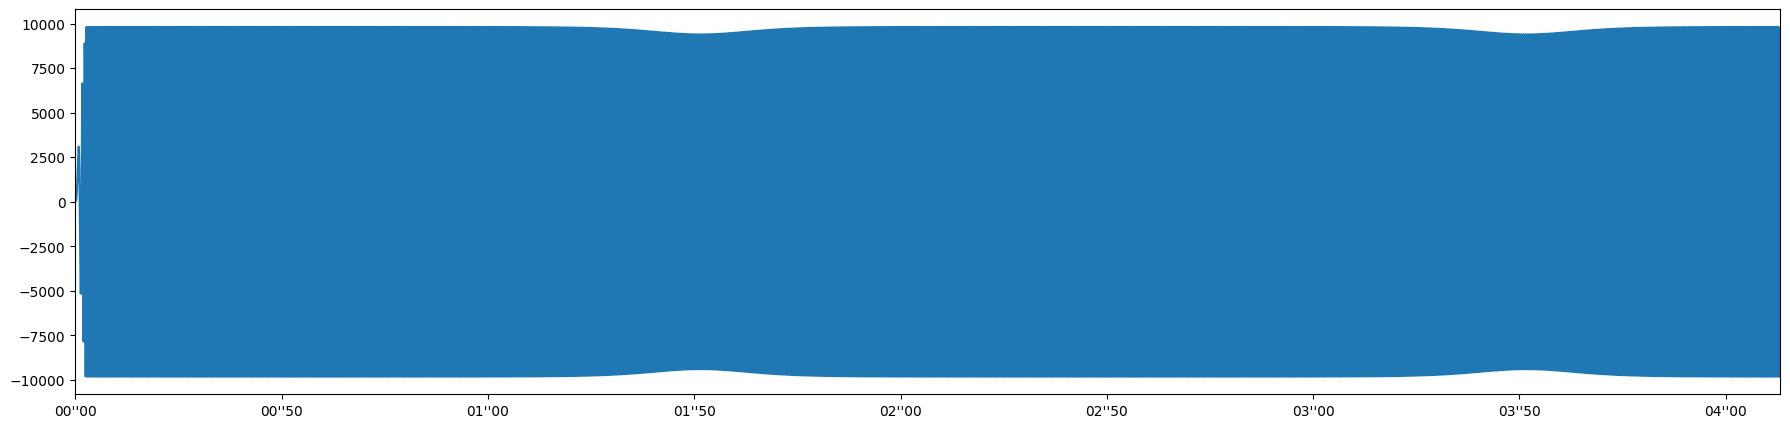

In [ ]:
disp_wf(wf, sr)

In [ ]:
import recode 

recode.decode_wav_header_bytes(wav_bytes)

{'sr': 44100,
 'width_bytes': 2,
 'n_channels': 1,
 'nframes': 137005,
 'comptype': None}

In [ ]:
synth = Synth(dual_osc_graph)
list(synth.knobs)

['freq1', 'freq2', 'amp', 'lfo_freq']

In [ ]:
synth.knobs['freq1'] = 440

In [ ]:
synth.knobs['freq2'] *= 2

In [ ]:
synth.knobs._update_log

[{'freq1': 440}, {'freq2': 660}]

In [ ]:
synth.knobs(freq1=100)

In [ ]:
synth.knobs._update_log

[{'freq1': 440}, {'freq2': 660}, {'freq1': 100}]

In [ ]:
from hum import Synth, disp_wf
import time
from pyo import Sine, ButLP, SigTo, Mix

# Dual sine oscillator with LFO-controlled lowpass filter
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)


synth = Synth(dual_osc_graph)


In [ ]:
from inspect import signature

with synth:
    print(signature(synth.knobs))
    print(list(synth.knobs))

(*, freq1, freq2, amp, lfo_freq)
['freq1', 'freq2', 'amp', 'lfo_freq']


In [ ]:
with synth:
    time.sleep(0.1)
    synth.knobs

{'freq1': 220, 'freq2': 330, 'amp': 0.3, 'lfo_freq': 0.5}

In [ ]:
s = records[1][1]['freq2']
dir(s)


['add', 'mul', 'time', 'value']

NameError: name 's' is not defined